This notebook demonstrates the pipeline for using the equivalent linear method to perform site response analysis.

In [1]:
from PySeismoSoil.class_Vs_profile import Vs_Profile
from PySeismoSoil.class_ground_motion import Ground_Motion
from PySeismoSoil.class_curves import Multiple_GGmax_Curves, Multiple_Damping_Curves, Multiple_GGmax_Damping_Curves
from PySeismoSoil.class_hh_calibration import HH_Calibration
from PySeismoSoil.class_damping_calibration import Damping_Calibration
from PySeismoSoil.class_simulation import Equiv_Linear_Simulation

To perform an equivalent linear analysis, we need the following information:

- Input acceleration
- $V_S$ profile
- $G/G_{\max}$ and damping curves (of every soil layer)

In [2]:
input_accel = Ground_Motion('../PySeismoSoil/tests/files/sample_accel.txt', unit='cm/s/s')
vs_profile = Vs_Profile('../PySeismoSoil/tests/files/profile_FKSH14.txt')

(`Vs_Profile` class: [documentation](https://pyseismosoil.readthedocs.io/en/stable/api_docs/class_Vs_profile.html) and [examples](./Demo_02_Vs_Profile.ipynb). `Ground_Motion` class: [documentations](https://pyseismosoil.readthedocs.io/en/stable/api_docs/class_ground_motion.html) and [examples](./Demo_01_Ground_Motion.ipynb).)


----------+----------+-------------+------------------+--------------
  Thk [m] | Vs [m/s] | Damping [%] | Density [kg/m^3] | Material No. 
----------+----------+-------------+------------------+--------------
   2.00   |  120.0   |    2.000    |      1466.0      |      1       
   6.00   |  190.0   |    2.000    |      1900.0      |      2       
  44.00   |  280.0   |    2.000    |      1900.0      |      3       
  54.00   |  1030.0  |    2.000    |      2125.0      |      4       
   9.00   |  1210.0  |    1.000    |      2243.0      |      5       
   0.00   |  1210.0  |    1.000    |      2243.0      |      0       
----------+----------+-------------+------------------+--------------

(Vs30 = 236.6 m/s)



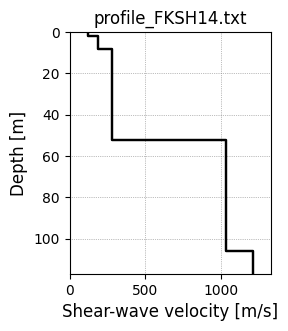

In [3]:
vs_profile.summary()

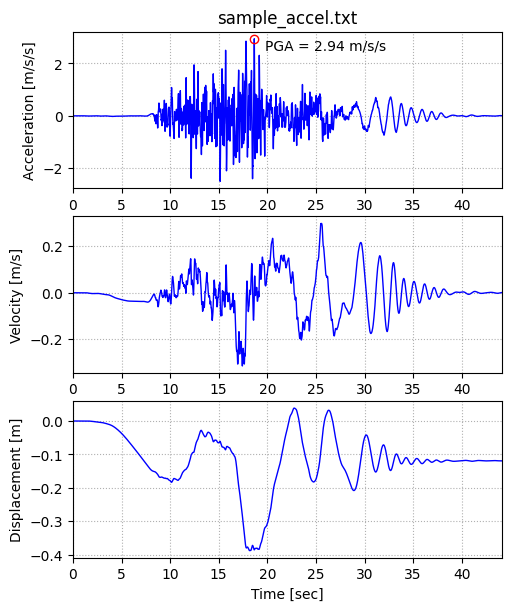

In [4]:
input_accel.plot();

The users often only know the $V_S$ profile and the input motion. In this case, we can empirically estimate $G/G_{\max}$ and damping curves from the $V_S$ profile:

Estimate $G/G_{\max}$ curves from the $V_S$ profile, using the "HH calibration" procedure proposed by [Shi and Asimaki (2017)](http://resolver.caltech.edu/CaltechAUTHORS:20170404-150827374) via the [`HH_Calibration` class](./Pipeline_02_HH_Calibration.ipynb):

In [5]:
hh_c = HH_Calibration(vs_profile)
hh_g_param = hh_c.fit()
ggmax_curves, _ = hh_g_param.construct_curves()

========== Start optimizing for HH_G parameters ===========
------ G/Gmax not provided; will generate MKZ curves using Darendeli (2001): ------
-----------  FKZ optimization  -----------------------------
1/5: mu = 0.220, a = 100.0, gamma_t = 0.052%, d = 0.902
2/5: mu = 0.206, a = 100.0, gamma_t = 0.023%, d = 0.844
3/5: mu = 0.265, a = 100.0, gamma_t = 0.044%, d = 0.865
4/5: mu = 1.000, a = 100.0, gamma_t = 0.011%, d = 0.981
5/5: mu = 1.000, a = 100.0, gamma_t = 0.010%, d = 0.981


Estimate damping curves using empirical formulas proposed by [Darendeli (2001)](https://repositories.lib.utexas.edu/handle/2152/10396) via the [`Damping_Calibration` class](https://pyseismosoil.readthedocs.io/en/stable/api_docs/class_damping_calibration.html):

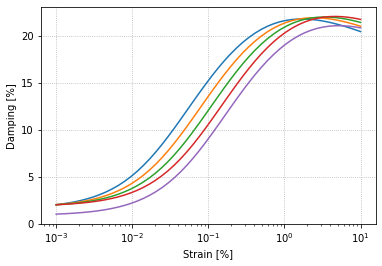

In [6]:
d_c = Damping_Calibration(vs_profile)
damping_curves = d_c.get_damping_curves(show_fig=True)

Merge `ggmax_curves` and `damping_curves` into one meta object:

In [7]:
ggmax_and_damping_curves = Multiple_GGmax_Damping_Curves(mgc_and_mdc=(ggmax_curves, damping_curves))

Initialize an `Equiv_Linear_Simulation` object. We use an "elastic" boundary condition in this example, which means that the input ground motion is the ground motion on a nearby reference rock site (or "rock outcrop site"). (If the input ground motion is the motion recorded in a borehole at the bottom of the $V_S$ profile, then use "rigid" as the boundary condition.)

In [8]:
eql_sim = Equiv_Linear_Simulation(vs_profile, input_accel, ggmax_and_damping_curves, boundary='elastic')

Then, run the simulation with the `run()` method:

Iteration No.1.  G_diff =  166.19%, D_diff =   83.58%
Iteration No.2.  G_diff =   20.88%, D_diff =   26.54%
Iteration No.3.  G_diff =    9.78%, D_diff =    8.68%
Iteration No.4.  G_diff =    4.61%, D_diff =    3.91%
---------- Convergence achieved ---------------


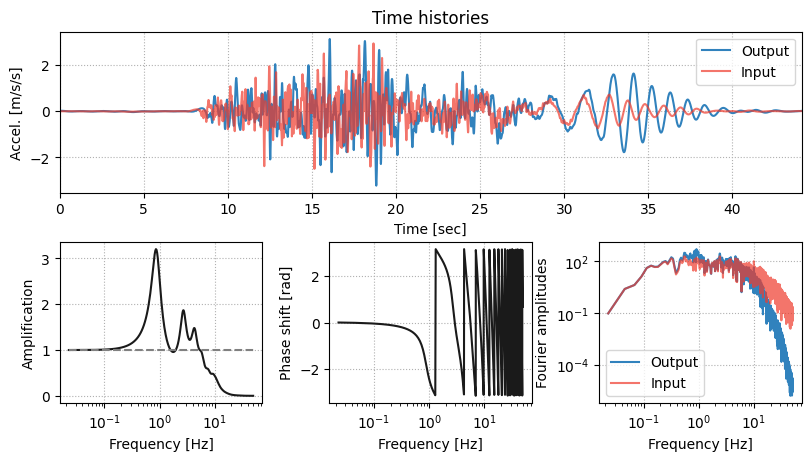

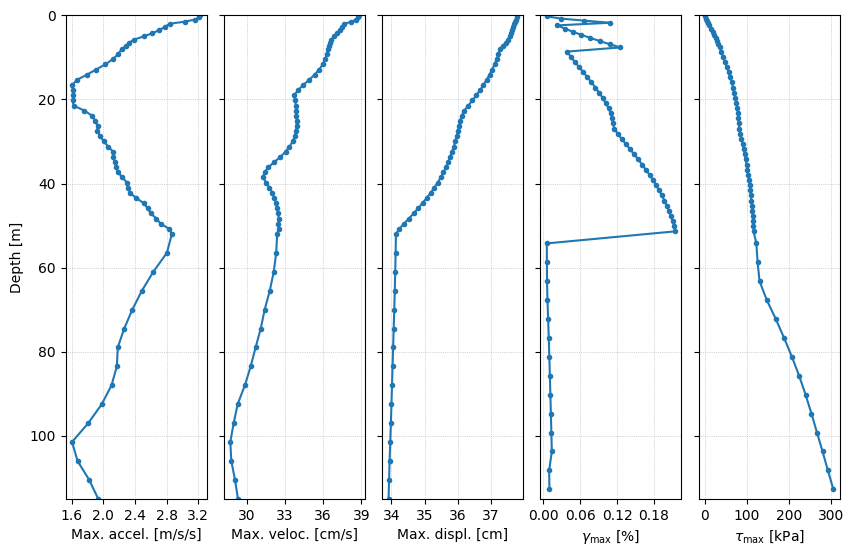

In [9]:
sim_results = eql_sim.run(verbose=True, show_fig=True)

You can save the simulation results `sim_results` to the hard drive like this:

```python
>>> sim_results.to_txt()
```

To also save the figures (input/output ground motion, maximum accel/veloc/displ/strain/stress profiles), use the `plot()` method:

```python
>>> sim_results.plot(dpi=200, save_fig=True)
```

For more information about the `Simulation_Results` class, see its [documentation](https://pyseismosoil.readthedocs.io/en/stable/api_docs/class_simulation_results.html).